スパースモデリング第15章　その他の応用
==
画像のインペインティング：局所K-SVD

In [120]:
import time
from sklearn.preprocessing import  normalize

In [109]:
from matplotlib import pyplot as plt 
import numpy as np
from matplotlib.font_manager import FontProperties
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
from skimage.io import imread

font_path = font_path = "/usr/share/fonts/truetype/migmix/migmix-1p-regular.ttf"
font_prop = FontProperties(fname=font_path)
plt.rc('font',family=font_prop.get_name())

def get_psnr(im, recon):
    """ PSNRを得る """ 
    return 10. * np.log(im.max() / np.sqrt(np.mean((im - recon) ** 2)))

def show_dictionary(A, name=None, figsize=(4, 4), vmin=None, vmax=None):
    """ 辞書を表示 """
    n = int(np.sqrt(A.shape[0]))
    m = int(np.sqrt(A.shape[1]))
    A_show = A.reshape((n, n, m, m))
    fig, ax = plt.subplots(m, m, figsize=figsize)
    for row in range(m):
        for col in range(m):
            ax[row, col].imshow(A_show[:, :, col, row], cmap='gray', interpolation='Nearest', vmin=vmin, vmax=vmax)
            ax[row, col].axis('off')
    if name is not None:
        plt.savefig(name, dpi=220)
        
def OMP(A, b, k0, eps):
    """ 
    直交マッチング追跡(orthogonal matching pursuit; OMP) 
    
    A nxm行列
    b n要素の観測
    k0 xの非ゼロの要素数
    eps 誤差の閾値
    
    戻り値
    x m要素のスパース表現
    S m要素のサポートベクトル
    """
    # 初期化
    x = np.zeros(A.shape[1])
    S = np.zeros(A.shape[1], dtype=np.uint8)
    r = b.copy()
    rr = np.dot(r, r)
    for _ in range(k0):
        # 誤差計算
        err = rr - np.dot(A[:, S == 0].T, r) ** 2
            
        # サポート更新
        ndx = np.where(S == 0)[0]
        S[ndx[err.argmin()]] = 1
    
        # 解更新
        As = A[:, S == 1]
        pinv = np.linalg.pinv(np.dot(As, As.T))
        x[S == 1] = np.dot(As.T, np.dot(pinv, b))
        
        # 残差更新
        r = b - np.dot(A, x)
        rr = np.dot(r, r)
        if rr < eps:
            break
            
    return x, S

Peppers
--

In [110]:
import skimage 

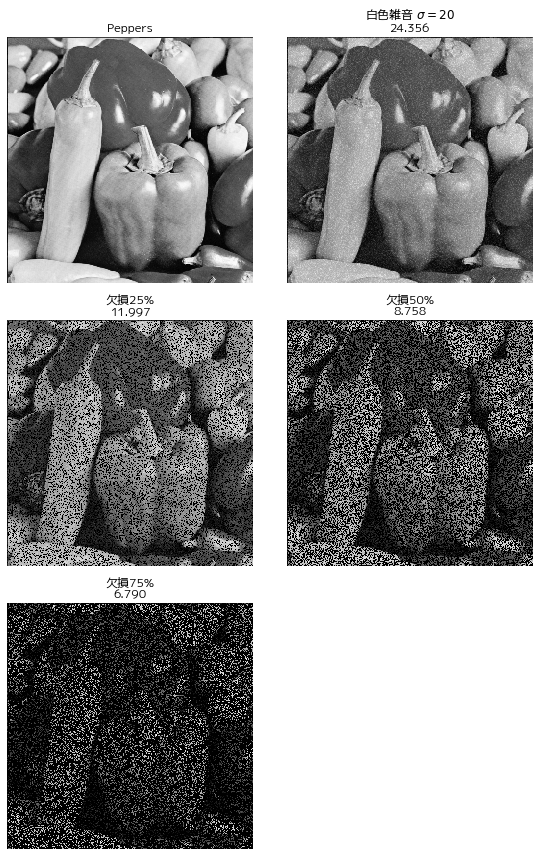

In [113]:
start = time.time()
im = skimage.color.rgb2gray(imread('../sparse-modeling/peppers.png'))[::2, ::2] * 255
sig = 20.

if np.any(im < 0): print('im is Nonnegative')

if True:
    Y = im + np.abs(np.random.randn(im.shape[0], im.shape[1])) * sig
    mask = abs(np.random.rand(im.shape[0], im.shape[1]))
    mask_25 = mask > 0.25
    mask_50 = mask > 0.5
    mask_75 = mask > 0.75
    Y_25 = Y * mask_25
    Y_50 = Y * mask_50
    Y_75 = Y * mask_75
    Y.tofile('Peppers_Y_sig20')
    Y_25.tofile('Peppers_Y_sig20_25')
    Y_50.tofile('Peppers_Y_sig20_50')
    Y_75.tofile('Peppers_Y_sig20_75')
    mask.tofile('mask')
    mask_25.tofile('mask_25')
    mask_50.tofile('mask_50')
    mask_75.tofile('mask_75')
else:
    print('Here')
    Y = np.fromfile('Peppers_Y_sig20').reshape(im.shape)
    Y_25 = np.fromfile('Peppers_Y_sig20_25').reshape(im.shape)
    Y_50 = np.fromfile('Peppers_Y_sig20_50').reshape(im.shape)
    Y_75 = np.fromfile('Peppers_Y_sig20_75').reshape(im.shape)
    mask = np.fromfile('mask').reshape(im.shape)
    mask_25 = np.fromfile('mask_25', dtype=np.uint8).reshape(im.shape)
    mask_50 = np.fromfile('mask_50', dtype=np.uint8).reshape(im.shape)
    mask_75 = np.fromfile('mask_75', dtype=np.uint8).reshape(im.shape)

if np.any(Y < 0): print('Y is nonnegative')

fig, ax = plt.subplots(3, 2, figsize=(8, 12))
ax = ax.flatten()
ax[0].imshow(im, cmap='gray', interpolation='Nearest')
ax[1].imshow(Y, cmap='gray', interpolation='Nearest')
ax[2].imshow(Y_25, cmap='gray', interpolation='Nearest')
ax[3].imshow(Y_50, cmap='gray', interpolation='Nearest')
ax[4].imshow(Y_75, cmap='gray', interpolation='Nearest')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[3].axis('off')
ax[4].axis('off')
ax[0].set_title('Peppers')
ax[1].set_title('白色雑音 '+r'$\sigma = 20$'+'\n{:.3f}'.format(get_psnr(im, Y)))
ax[2].set_title('欠損25%\n{:.3f}'.format(get_psnr(im, Y_25)))
ax[3].set_title('欠損50%\n{:.3f}'.format(get_psnr(im, Y_50)))
ax[4].set_title('欠損75%\n{:.3f}'.format(get_psnr(im, Y_75)))
ax[-1].axis('off')
plt.tight_layout()
plt.savefig('Peppers_inpaint.png', dpi=220)

冗長DCT辞書
--

In [132]:
patch_size = 8
dict_size = 16 * 2
A_1D = np.zeros((patch_size, dict_size))
for k in np.arange(dict_size):
    for i in np.arange(patch_size):
        A_1D[i, k] = np.cos(i * k * np.pi / float(dict_size))
    if k != 0:
        A_1D[:, k] -= A_1D[:, k].mean()

A_DCT = np.kron(A_1D, A_1D)
A_DCT.tofile('A_DCT')

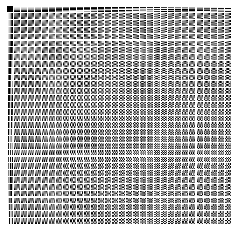

In [133]:
A_DCT = np.fromfile('A_DCT').reshape((patch_size ** 2, dict_size ** 2))
show_dictionary(A_DCT)

In [135]:
A_DCT.shape

(64, 1024)

In [127]:
normalize(A_DCT)[:, 0]

array([0.0733945 , 0.09810967, 0.09810967, 0.09810967, 0.09810967,
       0.09810967, 0.09810967, 0.09810967, 0.09810967, 0.13114754,
       0.13114754, 0.13114754, 0.13114754, 0.13114754, 0.13114754,
       0.13114754, 0.09810967, 0.13114754, 0.13114754, 0.13114754,
       0.13114754, 0.13114754, 0.13114754, 0.13114754, 0.09810967,
       0.13114754, 0.13114754, 0.13114754, 0.13114754, 0.13114754,
       0.13114754, 0.13114754, 0.09810967, 0.13114754, 0.13114754,
       0.13114754, 0.13114754, 0.13114754, 0.13114754, 0.13114754,
       0.09810967, 0.13114754, 0.13114754, 0.13114754, 0.13114754,
       0.13114754, 0.13114754, 0.13114754, 0.09810967, 0.13114754,
       0.13114754, 0.13114754, 0.13114754, 0.13114754, 0.13114754,
       0.13114754, 0.09810967, 0.13114754, 0.13114754, 0.13114754,
       0.13114754, 0.13114754, 0.13114754, 0.13114754])

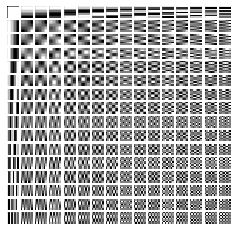

In [121]:
show_dictionary(normalize(A_DCT))

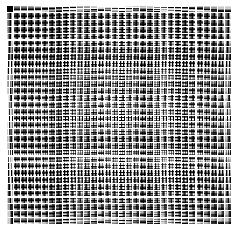

In [139]:
show_dictionary(np.abs(A_DCT[:, :]))

In [128]:
np.any(normalize(A_DCT) < 0)

True

In [18]:
tes = np.array([0, -1., 2, 4])

In [19]:
tes[tes < 0] = 0.001
tes

array([0.e+00, 1.e-03, 2.e+00, 4.e+00])

In [88]:
X = np.random.ranf(20*50).reshape(20,50)
np.any(X < 0)

False

マスク付き辞書学習の解法
--

In [118]:
class DctionaryLearning(object):    
    """ 辞書学習 """
    def NSR(self, Y, sig, m, alpha=0.001, n_iter=50, A0=None, initial_dictionary=None, mask=None):

        if initial_dictionary is None:
            A = Y[:, :m]
            A = np.dot(A, np.diag(1. / np.sqrt(np.diag(np.dot(A.T, A)))))

        else:
            A = initial_dictionary.copy()

        X = np.random.ranf(A.shape[1]*Y.shape[1]).reshape(A.shape[1], Y.shape[1])
        eps = A.shape[0] * (sig ** 2)

        ndx = np.arange(m)
        log = []

        
        
        for k in range(n_iter):
            
            """
            if mask is None:
                for i in range(Y.shape[1]):
                    X[:, i], _ = OMP(A, Y[:, i], k0, eps=eps)
            else:
                # マスクあり
                for i in range(Y.shape[1]):
                    A_mask = A[mask[:, i] == 1, :]
                    Y_mask = Y[mask[:, i] == 1, i]
                    eps = len(Y_mask) * (sig ** 2) * 1.1
                    X[:, i], _ = OMP(A_mask, Y_mask, k0, eps=eps)
                    Y[mask[:, i] == 0, i] = np.dot(A[mask[:, i] == 0, :], X[:, i])
            """
            if np.any(A < 0):
                print('Nonnegative A:', A)
            if np.any(X < 0):
                print('Nonnegative X:', X)
            
            A_bunsi = Y @ X.T
            A_bunbo = A @ (X @ X.T)
            A = A * (A_bunsi / A_bunbo)
            X_bunsi = A.T @ Y
            X_bunbo = (A.T @ A) @ X
            X = X * (X_bunsi / X_bunbo)
            

            A[A < 1e-7] = 1e-7
            X[X < 1e-7] = 1e-7
            
            
            
            opt = np.abs(Y - np.dot(A, X)).mean()
            print(k, opt)
        return A, np.array(log)
    
    def MOD(self, Y, sig, m, k0, n_iter=50, A0=None, initial_dictionary=None):
        """ 
        MOD辞書学習アルゴリズム 
        
        Y 信号事例、n×M、nは事例の次元、Mは事例の総数
        sig ノイズレベル
        m 辞書の列数
        k0 非ゼロ要素の個数
        """
        if initial_dictionary is None:
            A = Y[:, :m]
            A = np.dot(A, np.diag(1. / np.sqrt(np.diag(np.dot(A.T, A)))))
        else:
            A = initial_dictionary
        X = np.zeros((A.shape[1], Y.shape[1]))
        eps = A.shape[0] * (sig ** 2)

        log = []
        for k in range(n_iter):
            for i in range(Y.shape[1]):
                X[:, i], _ = OMP(A, Y[:, i], k0, eps=eps)

            opt = np.abs(Y - np.dot(A, X)).mean()
            
            A = np.dot(Y, np.dot(X.T, np.linalg.pinv(np.dot(X, X.T))))
            A = np.dot(A, np.diag(1. / np.sqrt(np.diag(np.dot(A.T, A)))))
            
            if A0 is not None:
                opt2 = self.percent_recovery_of_atoms(A, A0)
                log.append((opt, opt2))
            else:
                log.append(opt)            
            print(k, log[k])

        return A, np.array(log)
    
    def KSVD(self, Y, sig, m, k0, n_iter=50, A0=None, initial_dictionary=None, mask=None):
        """ 
        K-SVD辞書学習アルゴリズム
        
        Y 信号事例、n×M、nは信号の次元、Mは事例の総数
        sig ノイズレベル
        m 辞書の列数
        k0 非ゼロ要素の個数

        参考
        https://github.com/greyhill/pypbip/blob/master/ksvd.py
        """
        if initial_dictionary is None:
            A = Y[:, :m]
            A = np.dot(A, np.diag(1. / np.sqrt(np.diag(np.dot(A.T, A)))))
        else:
            A = initial_dictionary.copy()
        X = np.zeros((A.shape[1], Y.shape[1]))
        eps = A.shape[0] * (sig ** 2)

        ndx = np.arange(m)
        log = []
        for k in range(n_iter):
            if mask is None:
                for i in range(Y.shape[1]):
                    X[:, i], _ = OMP(A, Y[:, i], k0, eps=eps)
            else:
                # マスクあり
                for i in range(Y.shape[1]):
                    A_mask = A[mask[:, i] == 1, :]
                    Y_mask = Y[mask[:, i] == 1, i]
                    eps = len(Y_mask) * (sig ** 2) * 1.1
                    X[:, i], _ = OMP(A_mask, Y_mask, k0, eps=eps)
                    Y[mask[:, i] == 0, i] = np.dot(A[mask[:, i] == 0, :], X[:, i])
                    
            for j in ndx:      
                x_using = X[j, :] != 0
                if np.sum(x_using) == 0:
                    continue
                X[j, x_using] = 0
                Residual_err = Y[:, x_using] - np.dot(A, X[:, x_using])                 
                U, s, Vt = np.linalg.svd(Residual_err)
                A[:, j] = U[:, 0]
                X[j, x_using] = s[0] * Vt.T[:, 0]

            opt = np.abs(Y - np.dot(A, X)).mean()
            if A0 is not None:
                opt2 = self.percent_recovery_of_atoms(A, A0)
                log.append((opt, opt2))
            else:
                log.append(opt)            
            print(k, log[k])

        return A, np.array(log)

    def percent_recovery_of_atoms(self, A, A0, threshold=0.99):
        """ アトムの復元率を測る """
        num = 0
        for m in range(A.shape[1]):
            a = A0[:, m]
            if np.abs(np.dot(a, A)).max() > threshold:
                num += 1
        return float(num) / A.shape[1] * 100

In [8]:
def dictionary_learning_with_mask(im, mask, A_DCT, patch_size=8, n_iter=15):
    """ マスク付き辞書学習を実行 """
    dl = DctionaryLearning()
    patches = extract_patches_2d(im, (patch_size, patch_size)).reshape((-1, patch_size ** 2))
    mask_patches = extract_patches_2d(mask, (patch_size, patch_size)).reshape((-1, patch_size ** 2))
    M = len(patches)
    print(M)
    
    A_KSVD = A_DCT.copy()
    for _ in range(n_iter):
        ndx = np.random.permutation(M)[:A_DCT.shape[1] * 50]
        #A_KSVD, _ = dl.KSVD(patches[ndx].T, 20., 256, 4, mask=mask_patches[ndx].T, n_iter=1, initial_dictionary=A_KSVD)
        A_KSVD, _ = dl.KSVD(patches[ndx].T, 20., 256, 4,  mask=None, n_iter=1, initial_dictionary=A_KSVD)

    return A_KSVD

In [103]:
def dictionary_learning_with_mask2(im, mask, A_DCT, patch_size=8, n_iter=15):
    """ マスク付き辞書学習を実行 """
    dl = DctionaryLearning()
    patches = extract_patches_2d(im, (patch_size, patch_size)).reshape((-1, patch_size ** 2))
    mask_patches = extract_patches_2d(mask, (patch_size, patch_size)).reshape((-1, patch_size ** 2))
    M = len(patches)
    print(M)
    
    A_KSVD = A_DCT.copy()
    print('n_iter dl with mask2:', n_iter)
    for _ in range(n_iter):
        ndx = np.random.permutation(M)[:A_DCT.shape[1] * 50]
        A_KSVD, _ = dl.NSR(patches[ndx].T, 20., 256, alpha=0, mask=mask_patches[ndx].T, n_iter=1, initial_dictionary=A_KSVD)

    return A_KSVD

In [115]:
np.any(Y_25 < 0)

False

In [119]:
#%debug
A_KSVD_25 = dictionary_learning_with_mask2(Y_25, mask_25, A_DCT, n_iter=1)
A_KSVD_25.tofile('A_KSVD_25')

62001
n_iter dl with mask2: 1
Nonnegative A: [[ 1.          0.30292685  0.875      ...  0.8667863   0.82569875
   0.8904861 ]
 [ 1.          0.28371213  0.79887953 ... -0.86149046 -0.98978116
  -0.97869324]
 [ 1.          0.22680638  0.58210678 ...  0.284252    0.54930839
   0.81865459]
 ...
 [ 1.         -0.14150292 -0.50768343 ... -0.22612171 -0.06479053
   0.15385649]
 [ 1.         -0.31438972 -0.83210678 ...  0.25277694  0.20922044
  -0.08205296]
 [ 1.         -0.50198283 -1.04887953 ... -0.11920793 -0.20086596
   0.06321936]]
0 195.18599108239297


A_KSVD_25 = dictionary_learning_with_mask(Y_25, mask_25, A_DCT)
A_KSVD_25.tofile('A_KSVD_25')

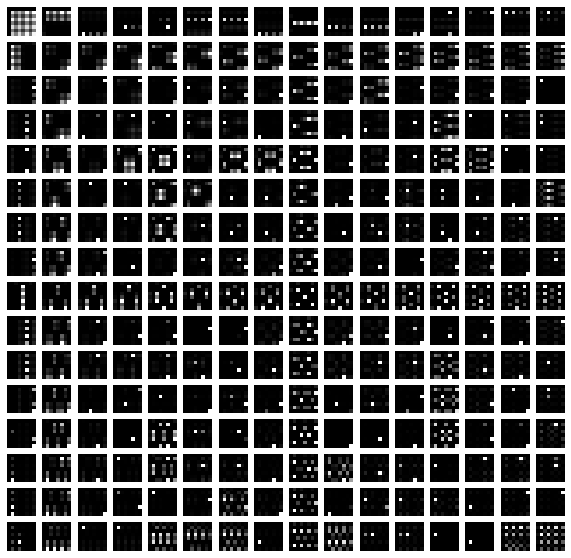

In [80]:
A_KSVD_25 = np.fromfile('A_KSVD_25').reshape((patch_size ** 2, dict_size ** 2))
show_dictionary(A_KSVD_25, name='A_KSVD_25.png', figsize=(10, 10))

In [18]:
A_KSVD_50 = dictionary_learning_with_mask(Y_50, mask_50, A_DCT)
A_KSVD_50.tofile('A_KSVD_50')

62001
0 8.922504838989186
0 9.144589298724215
0 8.836415113466087
0 8.760810411507936
0 8.658612310519636
0 8.66639101670914
0 8.637475990238201
0 8.608550821925206
0 8.572838948659035
0 8.576622322725242
0 8.557564331387617
0 8.526463176179202
0 8.552020811654696
0 8.479712630477104
0 8.470838348173071


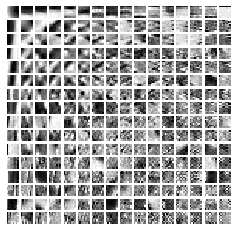

In [19]:
A_KSVD_50 = np.fromfile('A_KSVD_50').reshape((patch_size ** 2, dict_size ** 2))
show_dictionary(A_KSVD_50, name='A_KSVD_50.png')

In [20]:
A_KSVD_75 = dictionary_learning_with_mask(Y_75, mask_75, A_DCT)
A_KSVD_75.tofile('A_KSVD_75')

62001
0 4.203493679900277
0 5.157500872484579
0 4.153684922380816
0 4.153681603900611
0 4.142195191841144
0 4.12924605233906
0 4.111511314273305
0 4.140881486735734
0 4.1127161070234814
0 4.1111278761013565
0 4.101807472682573
0 4.136308847326122
0 4.108437742249569
0 4.137995243865267
0 4.139498911869993


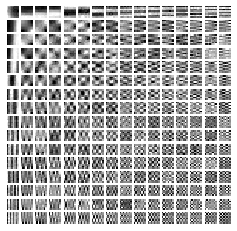

In [21]:
A_KSVD_75 = np.fromfile('A_KSVD_75').reshape((patch_size ** 2, dict_size ** 2))
show_dictionary(A_KSVD_75, name='A_KSVD_75.png')

マスク付きスパース符号化
--

In [13]:
def sparse_coding_with_mask(im, A, k0, sig, mask, patch_size=8):
    """ マスク付きスパース符号化 """        
    patches = extract_patches_2d(im, (patch_size, patch_size))
    mask_patches = extract_patches_2d(mask, (patch_size, patch_size))
    q = np.zeros((len(patches), A.shape[1]))
    for i, (patch, mask_patch) in enumerate(zip(patches, mask_patches)):
        if i % 1000 == 0:
            print(i)
        A_mask = A[mask_patch.flatten() == 1, :]
        patch_mask = patch[mask_patch == 1]
        eps = len(patch_mask) * (sig ** 2) * 1.1
        q[i], _ = OMP(A_mask, patch_mask, k0, eps=eps)
    return q

def recon_image(im, q, A, lam=0.5, patch_size=8):
    """ 画像の再構成 """
    recon_patches = (np.dot(A, q.T).T).reshape((-1, patch_size, patch_size))
    recon = reconstruct_from_patches_2d(recon_patches, im.shape)
    return (im * lam + recon) / (lam + 1.)

In [49]:
q_25_KSVD = sparse_coding_with_mask(Y_25, A_KSVD_25, 4, sig, mask_25)


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000


In [23]:
q_25_KSVD = sparse_coding_with_mask(Y_25, A_KSVD_25, 4, sig, mask_25)
q_50_KSVD = sparse_coding_with_mask(Y_50, A_KSVD_50, 4, sig, mask_50)
q_75_KSVD = sparse_coding_with_mask(Y_75, A_KSVD_75, 4, sig, mask_75)
q_25_KSVD.tofile('Peppers_q_25_KSVD')
q_50_KSVD.tofile('Peppers_q_50_KSVD')
q_75_KSVD.tofile('Peppers_q_75_KSVD')

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
4

In [24]:
end = time.time()

In [25]:
print('during time:', end - start, '[s]')

during time: 1102.1779482364655 [s]


In [14]:
A_KSVD_25 = np.fromfile('A_KSVD_25').reshape((patch_size ** 2, dict_size ** 2))
q_25_KSVD = np.fromfile('Peppers_q_25_KSVD').reshape((-1, dict_size ** 2))
Y_25_recon_KSVD = recon_image(Y_25, q_25_KSVD, A_KSVD_25, lam=0)
Y_25_recon_KSVD.tofile('Peppers_recon_Y_sig20_25_KSVD')


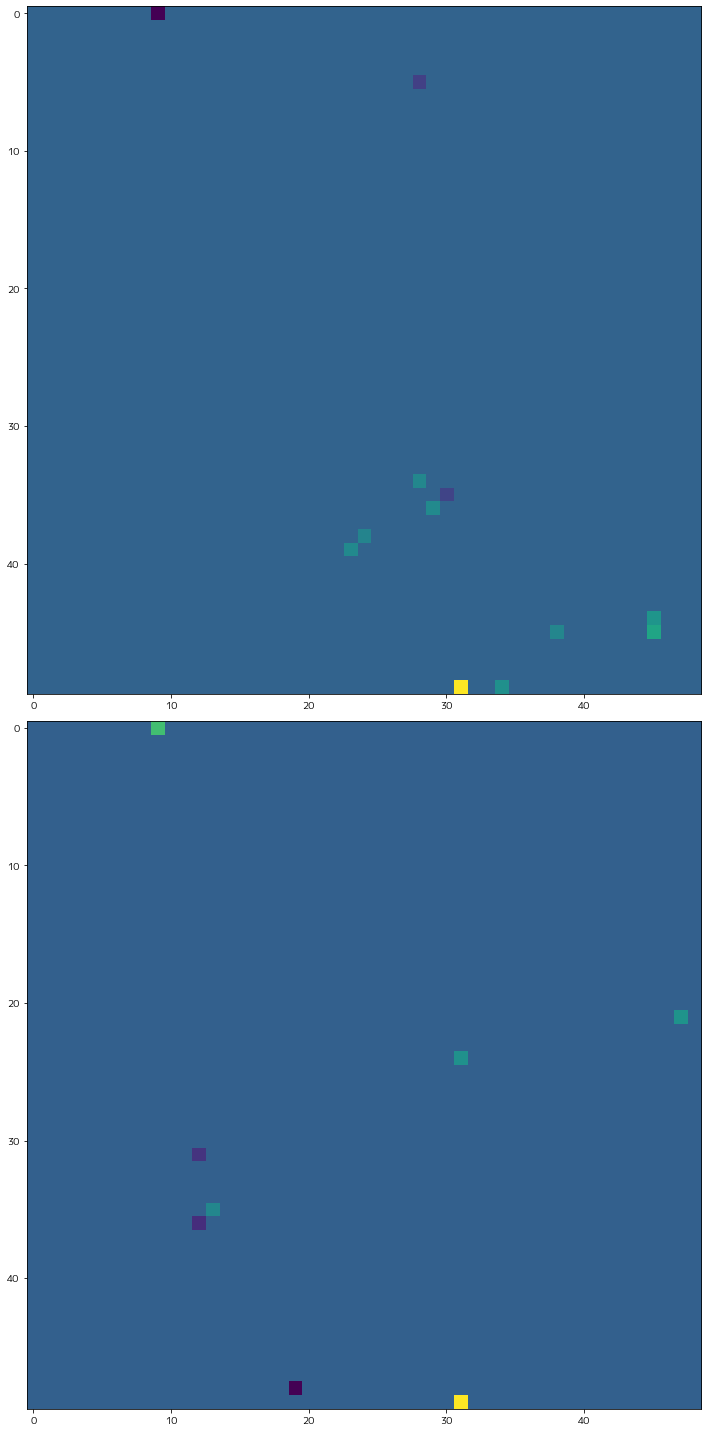

In [46]:
plt.figure(figsize=(20, 20))
plt.subplot(2,1,1)
plt.imshow(q_25_KSVD[:50, 1:50], interpolation=None)
plt.subplot(2,1,2)
plt.imshow(q_50_KSVD[:50, 1:50], interpolation=None)
plt.tight_layout()

In [36]:
A_KSVD_25 = np.fromfile('A_KSVD_25').reshape((patch_size ** 2, dict_size ** 2))
A_KSVD_50 = np.fromfile('A_KSVD_50').reshape((patch_size ** 2, dict_size ** 2))
A_KSVD_75 = np.fromfile('A_KSVD_75').reshape((patch_size ** 2, dict_size ** 2))
q_25_KSVD = np.fromfile('Peppers_q_25_KSVD').reshape((-1, dict_size ** 2))
q_50_KSVD = np.fromfile('Peppers_q_50_KSVD').reshape((-1, dict_size ** 2))
q_75_KSVD = np.fromfile('Peppers_q_75_KSVD').reshape((-1, dict_size ** 2))
Y_25_recon_KSVD = recon_image(Y_25, q_25_KSVD, A_KSVD_25, lam=0)
Y_50_recon_KSVD = recon_image(Y_50, q_50_KSVD, A_KSVD_50, lam=0)
Y_75_recon_KSVD = recon_image(Y_75, q_75_KSVD, A_KSVD_75, lam=0)
Y_25_recon_KSVD.tofile('Peppers_recon_Y_sig20_25_KSVD')
Y_50_recon_KSVD.tofile('Peppers_recon_Y_sig20_50_KSVD')
Y_75_recon_KSVD.tofile('Peppers_recon_Y_sig20_75_KSVD')

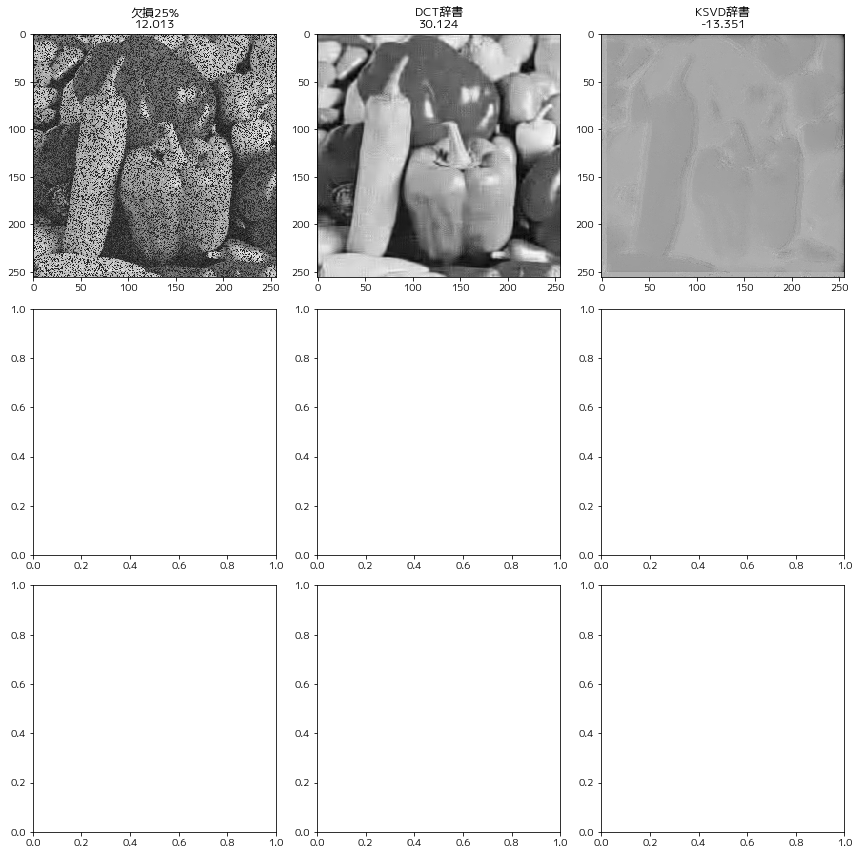

In [16]:
Y_25_recon = np.fromfile('Peppers_recon_Y_sig20_25').reshape(im.shape)
Y_25_recon_KSVD = np.fromfile('Peppers_recon_Y_sig20_25_KSVD').reshape(im.shape)
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
ax = ax.flatten()
ax[0].imshow(Y_25, cmap='gray', interpolation='Nearest')
ax[1].imshow(Y_25_recon, cmap='gray', interpolation='Nearest')
ax[2].imshow(Y_25_recon_KSVD, cmap='gray', interpolation='Nearest')
ax[0].set_title('欠損25%\n{:.3f}'.format(get_psnr(im, Y_25)))
ax[1].set_title('DCT辞書\n{:.3f}'.format(get_psnr(im, Y_25_recon)))
ax[2].set_title('KSVD辞書\n{:.3f}'.format(get_psnr(im, Y_25_recon_KSVD)))
plt.tight_layout()
plt.savefig('Peppers_recon_DCT_KSVD.png', dpi=220)

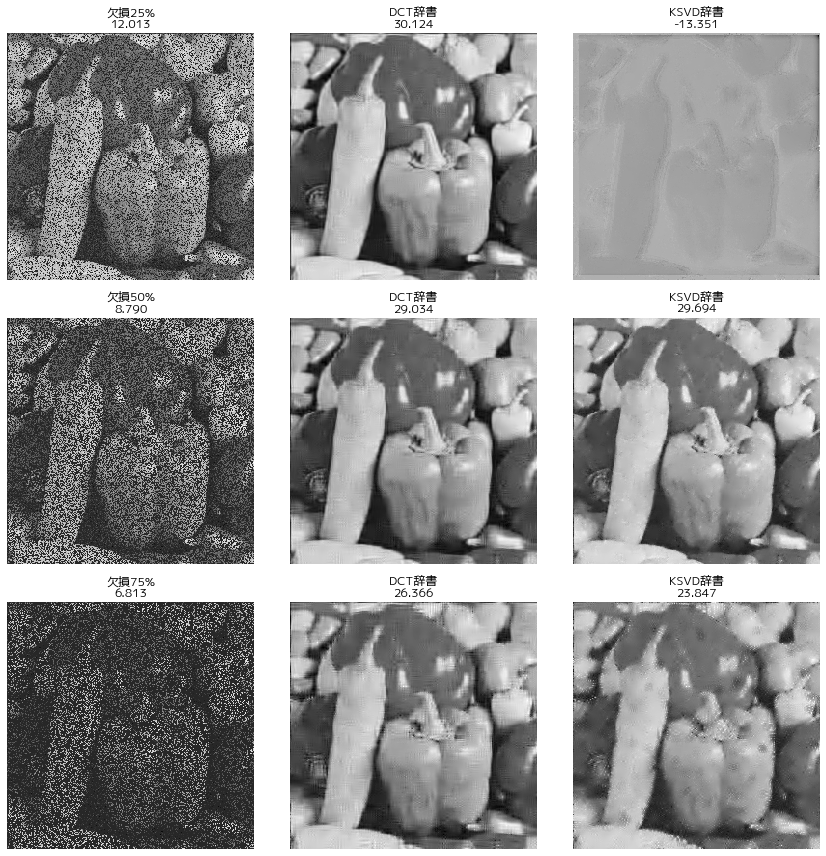

In [44]:
Y_25_recon = np.fromfile('Peppers_recon_Y_sig20_25').reshape(im.shape)
Y_50_recon = np.fromfile('Peppers_recon_Y_sig20_50').reshape(im.shape)
Y_75_recon = np.fromfile('Peppers_recon_Y_sig20_75').reshape(im.shape)
Y_25_recon_KSVD = np.fromfile('Peppers_recon_Y_sig20_25_KSVD').reshape(im.shape)
Y_50_recon_KSVD = np.fromfile('Peppers_recon_Y_sig20_50_KSVD').reshape(im.shape)
Y_75_recon_KSVD = np.fromfile('Peppers_recon_Y_sig20_75_KSVD').reshape(im.shape)

fig, ax = plt.subplots(3, 3, figsize=(12, 12))
ax = ax.flatten()
ax[0].imshow(Y_25, cmap='gray', interpolation='Nearest')
ax[1].imshow(Y_25_recon, cmap='gray', interpolation='Nearest')
ax[2].imshow(Y_25_recon_KSVD, cmap='gray', interpolation='Nearest')
ax[3].imshow(Y_50, cmap='gray', interpolation='Nearest')
ax[4].imshow(Y_50_recon, cmap='gray', interpolation='Nearest')
ax[5].imshow(Y_50_recon_KSVD, cmap='gray', interpolation='Nearest')
ax[6].imshow(Y_75, cmap='gray', interpolation='Nearest')
ax[7].imshow(Y_75_recon, cmap='gray', interpolation='Nearest')
ax[8].imshow(Y_75_recon_KSVD, cmap='gray', interpolation='Nearest')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[3].axis('off')
ax[4].axis('off')
ax[5].axis('off')
ax[6].axis('off')
ax[7].axis('off')
ax[8].axis('off')
ax[0].set_title('欠損25%\n{:.3f}'.format(get_psnr(im, Y_25)))
ax[1].set_title('DCT辞書\n{:.3f}'.format(get_psnr(im, Y_25_recon)))
ax[2].set_title('KSVD辞書\n{:.3f}'.format(get_psnr(im, Y_25_recon_KSVD)))
ax[3].set_title('欠損50%\n{:.3f}'.format(get_psnr(im, Y_50)))
ax[4].set_title('DCT辞書\n{:.3f}'.format(get_psnr(im, Y_50_recon)))
ax[5].set_title('KSVD辞書\n{:.3f}'.format(get_psnr(im, Y_50_recon_KSVD)))
ax[6].set_title('欠損75%\n{:.3f}'.format(get_psnr(im, Y_75)))
ax[7].set_title('DCT辞書\n{:.3f}'.format(get_psnr(im, Y_75_recon)))
ax[8].set_title('KSVD辞書\n{:.3f}'.format(get_psnr(im, Y_75_recon_KSVD)))
plt.tight_layout()
plt.savefig('Peppers_recon_DCT_KSVD.png', dpi=220)

In [28]:
im = imread('peppers.png', as_grey=True)[::2, ::2] * 255
Y_25 = np.fromfile('Peppers_Y_sig20_25').reshape(im.shape)
Y_50 = np.fromfile('Peppers_Y_sig20_50').reshape(im.shape)
Y_75 = np.fromfile('Peppers_Y_sig20_75').reshape(im.shape)
Y_25_recon_KSVD = np.fromfile('Peppers_recon_Y_sig20_25_KSVD').reshape(im.shape)
Y_50_recon_KSVD = np.fromfile('Peppers_recon_Y_sig20_50_KSVD').reshape(im.shape)
Y_75_recon_KSVD = np.fromfile('Peppers_recon_Y_sig20_75_KSVD').reshape(im.shape)

fig, ax = plt.subplots(3, 2, figsize=(8, 12))
ax = ax.flatten()
ax[0].imshow(Y_25, cmap='gray', interpolation='Nearest')
ax[1].imshow(Y_25_recon_KSVD, cmap='gray', interpolation='Nearest')
ax[2].imshow(Y_50, cmap='gray', interpolation='Nearest')
ax[3].imshow(Y_50_recon_KSVD, cmap='gray', interpolation='Nearest')
ax[4].imshow(Y_75, cmap='gray', interpolation='Nearest')
ax[5].imshow(Y_75_recon_KSVD, cmap='gray', interpolation='Nearest')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
ax[3].axis('off')
ax[4].axis('off')
ax[5].axis('off')
ax[0].set_title('欠損25%\n{:.3f}'.format(get_psnr(im, Y_25)))
ax[1].set_title('K-SVD辞書による局所的インペインティング\n{:.3f}'.format(get_psnr(im, Y_25_recon_KSVD)))
ax[2].set_title('欠損50%\n{:.3f}'.format(get_psnr(im, Y_50)))
ax[3].set_title('K-SVD辞書による局所的インペインティング\n{:.3f}'.format(get_psnr(im, Y_50_recon_KSVD)))
ax[4].set_title('欠損75%\n{:.3f}'.format(get_psnr(im, Y_75)))
ax[5].set_title('K-SVD辞書による局所的インペインティング\n{:.3f}'.format(get_psnr(im, Y_75_recon_KSVD)))
plt.tight_layout()
plt.savefig('Peppers_recon_KSVD.png', dpi=220)

TypeError: _open() got an unexpected keyword argument 'as_grey'